In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

df = pd.read_csv('advertising.csv')
pd.options.display.max_columns = None

In [27]:
# functions used for this project:

def convert_to_int(df_column):
    boolean_list = []
    for i in df_column:
        boolean_list.append(int(i))
    df_column = boolean_list
    return df_column

def cross_correlation(data):
    corr = data.corr()
    plt.figure(figsize=(10,6))
    sns.heatmap(corr, xticklabels=corr.columns.values,
               yticklabels=corr.columns.values)
    print(corr)
    
def creating_distplot(size, data, features):
    plt.figure(figsize=size)
    for i in range(len(features)):
        plt.subplot(5, 3, i+1)
        sns.distplot(data[features[i]])

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1018 non-null   float64
 1   Age                       1018 non-null   int64  
 2   Area Income               1018 non-null   float64
 3   Daily Internet Usage      1018 non-null   float64
 4   Ad Topic Line             1018 non-null   object 
 5   City                      1018 non-null   object 
 6   Male                      1018 non-null   int64  
 7   Country                   1018 non-null   object 
 8   Timestamp                 1018 non-null   object 
 9   Clicked on Ad             1014 non-null   float64
dtypes: float64(4), int64(2), object(4)
memory usage: 79.7+ KB


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1018 non-null   float64
 1   Age                       1018 non-null   int64  
 2   Area Income               1018 non-null   float64
 3   Daily Internet Usage      1018 non-null   float64
 4   Ad Topic Line             1018 non-null   object 
 5   City                      1018 non-null   object 
 6   Male                      1018 non-null   int64  
 7   Country                   1018 non-null   object 
 8   Timestamp                 1018 non-null   object 
 9   Clicked on Ad             1014 non-null   float64
dtypes: float64(4), int64(2), object(4)
memory usage: 79.7+ KB


In [4]:
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 0:53,0.0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 1:39,0.0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35,0.0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 2:31,0.0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 3:36,0.0


In [5]:
# converting Timestamp column to datetime 
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Daily Time Spent on Site  1018 non-null   float64       
 1   Age                       1018 non-null   int64         
 2   Area Income               1018 non-null   float64       
 3   Daily Internet Usage      1018 non-null   float64       
 4   Ad Topic Line             1018 non-null   object        
 5   City                      1018 non-null   object        
 6   Male                      1018 non-null   int64         
 7   Country                   1018 non-null   object        
 8   Timestamp                 1018 non-null   datetime64[ns]
 9   Clicked on Ad             1014 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(3)
memory usage: 79.7+ KB


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Daily Time Spent on Site  1018 non-null   float64       
 1   Age                       1018 non-null   int64         
 2   Area Income               1018 non-null   float64       
 3   Daily Internet Usage      1018 non-null   float64       
 4   Ad Topic Line             1018 non-null   object        
 5   City                      1018 non-null   object        
 6   Male                      1018 non-null   int64         
 7   Country                   1018 non-null   object        
 8   Timestamp                 1018 non-null   datetime64[ns]
 9   Clicked on Ad             1014 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(3)
memory usage: 79.7+ KB


In [7]:
# checking missing values for column 'Clicked on Ad'\
# four null values to be found here
print(df.isnull().sum())
print(f'Dataset has {df.shape[0]} rows and {df.shape[1]} columns')

Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Ad Topic Line               0
City                        0
Male                        0
Country                     0
Timestamp                   0
Clicked on Ad               4
dtype: int64
Dataset has 1018 rows and 10 columns


In [8]:
# checking null values to see if there are any peculiarities
df[df['Clicked on Ad'].isnull()]

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
131,67.36,37,73104.47,233.56,Future-proofed grid-enabled implementation,North Wesleychester,0,Jersey,2016-07-06 16:00:00,NaN
217,67.28,43,76246.96,155.80,Future-proofed coherent hardware,North Mercedes,1,Pakistan,2016-04-03 21:13:00,NaN
431,34.30,41,53167.68,160.74,Re-contextualized reciprocal interface,West Melaniefurt,1,Libyan Arab Jamahiriya,2016-05-16 14:50:00,NaN
722,46.89,48,72553.94,176.78,Polarized mission-critical structure,Chaseshire,1,Turkey,2016-07-17 13:22:00,NaN


In [9]:
# dropping null values as there are only 4
# new shape will be four less rows
df = df.dropna()
print(df.isnull().sum())
print(f'New dataframe has {df.shape[0]} rows and {df.shape[1]} columns')

Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Ad Topic Line               0
City                        0
Male                        0
Country                     0
Timestamp                   0
Clicked on Ad               0
dtype: int64
New dataframe has 1014 rows and 10 columns


In [16]:
# Engineering new datetime features
# splitting timestamp by month, day, and hour
# splitting by year is not necessary because all data was from 2016


df['timestamp_month'] = df['Timestamp'].dt.month
df['timestamp_day_of_month'] = df['Timestamp'].dt.day
df['timestamp_hour'] = df['Timestamp'].dt.hour

# further binning timestamp_hour into morning, afternoon, and evening
df['timestamp_is_morning'] = (df['timestamp_hour'] < 12) & (df['timestamp_hour'] >= 6)
df['timestamp_is_afternoon'] = (df['timestamp_hour'] >= 12) & (df['timestamp_hour'] < 19)
df['timestamp_is_night'] = (df['timestamp_hour'] >= 19) | (df['timestamp_hour'] < 6) | (df['timestamp_hour'] == 0)

# creating weekend/weekday timestamp columns
df['timestamp_is_weekday'] = df['Timestamp'].dt.weekday < 5
df['timestamp_is_weekend'] = df['Timestamp'].dt.weekday > 5

# converting all booleans to ints

df['timestamp_is_afternoon'] = convert_to_int(df['timestamp_is_afternoon'])
df['timestamp_is_morning'] = convert_to_int(df['timestamp_is_morning'])
df['timestamp_is_night'] = convert_to_int(df['timestamp_is_night'])
df['timestamp_is_weekday'] = convert_to_int(df['timestamp_is_weekday'])
df['timestamp_is_weekend'] = convert_to_int(df['timestamp_is_weekend'])

# engineering weekday feature for readability

weekday_names = {0 :'Monday', 1: 'Tuesday', 2:'Wednesday', 3: 'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

weekday_list = []

for i in df['Timestamp'].dt.weekday:
    weekday_list.append(weekday_names[i])

df['timestamp_day_of_week'] = weekday_list

# dropping timestamp column after engineering new features
# df = df.drop(columns='Timestamp')
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad,timestamp_month,timestamp_day_of_month,timestamp_hour,timestamp_is_morning,timestamp_is_afternoon,timestamp_is_night,timestamp_is_weekday,timestamp_is_weekend,timestamp_day_of_week
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:00,0.0,3,27,0,0,0,1,0,1,Sunday
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:00,0.0,4,4,1,0,0,1,1,0,Monday
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:00,0.0,3,13,20,0,0,1,0,1,Sunday
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:00,0.0,1,10,2,0,0,1,0,1,Sunday
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:00,0.0,6,3,3,0,0,1,1,0,Friday


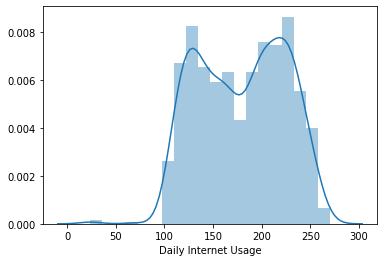

In [20]:
sns.distplot(df['Daily Internet Usage'], bins=20);

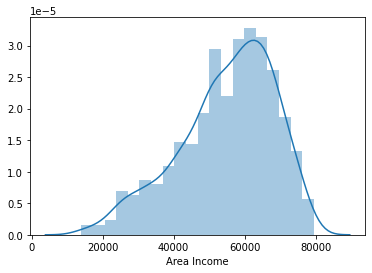

In [21]:
sns.distplot(df['Area Income'], bins=20);

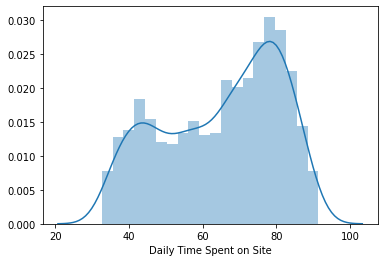

In [22]:
sns.distplot(df['Daily Time Spent on Site'], bins=20);

                          Daily Time Spent on Site       Age  Area Income  \
Daily Time Spent on Site                  1.000000 -0.118510     0.315234   
Age                                      -0.118510  1.000000    -0.094200   
Area Income                               0.315234 -0.094200     1.000000   
Daily Internet Usage                      0.510814 -0.135474     0.344017   
Male                                     -0.022830  0.025622    -0.006557   
Clicked on Ad                            -0.748947  0.166107    -0.477454   
timestamp_month                          -0.021894  0.020938    -0.057183   
timestamp_day_of_month                    0.000355 -0.049857    -0.018957   
timestamp_hour                           -0.002413 -0.012627     0.032951   
timestamp_is_morning                     -0.023328 -0.008873    -0.031606   
timestamp_is_afternoon                   -0.042628  0.041184    -0.047404   
timestamp_is_night                        0.058629 -0.029189     0.070149   

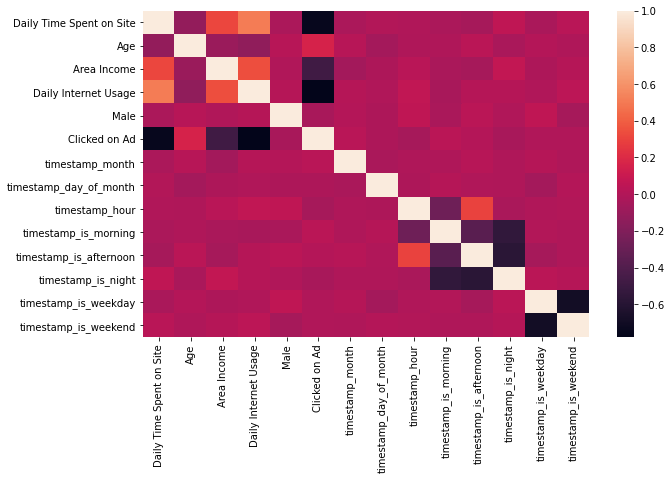

In [26]:
cross_correlation(df)

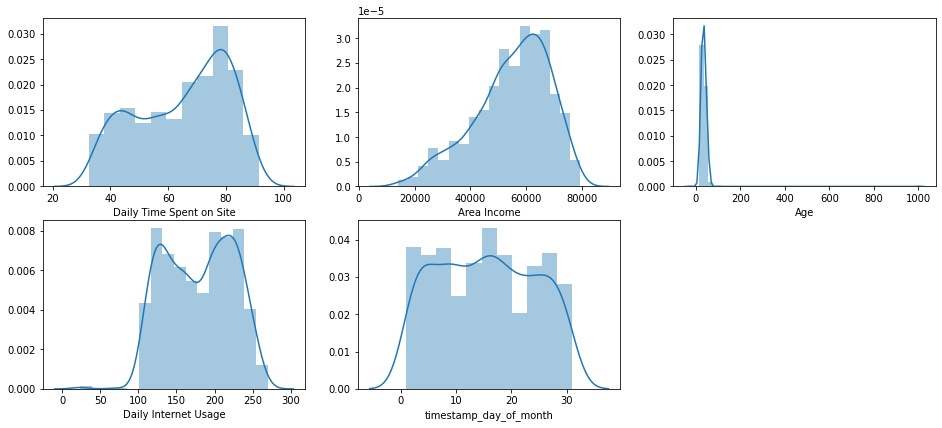

In [37]:
num_vars = ['Daily Time Spent on Site', 'Area Income', 'Age', 'Daily Internet Usage', 'timestamp_day_of_month']

# Creating distribution plots
creating_distplot((16,18), df, num_vars);
creating_distplot;